In [90]:
# @title Jraph imports (run cell)
%%capture
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku
!pip install networkx

In [91]:
# @title Imports (run cell)
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple

**Introduction**

Graphs are a powerful and general representation of data with a wide range of applications. You have probably seen some these applications before, such as social networks. Another popular application of graphs is molecular modelling. Molecules naturally lend themselves to graph representation, whereby atoms are nodes and covalent bonds edges. An example the Citronellal molecule, which is used to give citronella oil its distinctive lemon scent, is illustrated below.

**Section 1: Graphs, networkx**

NetworkX

NetworkX is a Python library focused on graphs and networks, offering a large number of useful methods, including visualization which we will use several times in this colab.

Let's create and draw a simple graph:

Graph G with 5 nodes and 5 edges
Adjacency list: [(0, 2), (0, 4), (0, 5), (4, 5), (5, 6)]
Adjacency matrix (symmetric):
[[0 1 1 1 0]
 [1 0 0 0 0]
 [1 0 0 1 0]
 [1 0 1 0 1]
 [0 0 0 1 0]]
Degree of node 0: 3


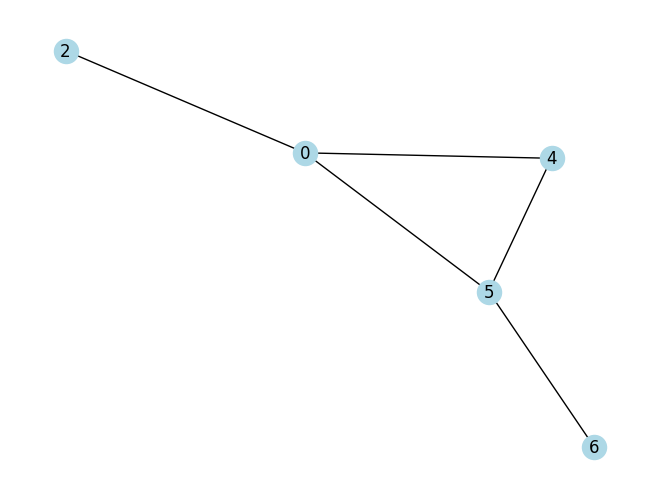

In [92]:
import networkx as nx

# Create a simple graph
G = nx.Graph() # Use DiGraph for directed graphs

G.add_nodes_from([0, 2, 4, 5, 6]) # Fill in the list of node labels as integers
G.add_edges_from([(0, 2), (0, 4), (4, 5), (5, 6), (0, 5)]) # Fill in the list of node pairs [(node_a, node_b)]
# Note that for a NetworkX (undirected) Graph, you do not need to provide both (node_a, node_b) and (node_b, node_a)

# Print basic info
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
print(f'Graph G with {nb_nodes} nodes and {nb_edges} edges')
print(f'Adjacency list: {G.edges}')
print(f'Adjacency matrix (symmetric):')
A = nx.adjacency_matrix(G) # Returns a sparse matrix
print(A.todense())
print(f'Degree of node 0: {G.degree(0)}')

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue')

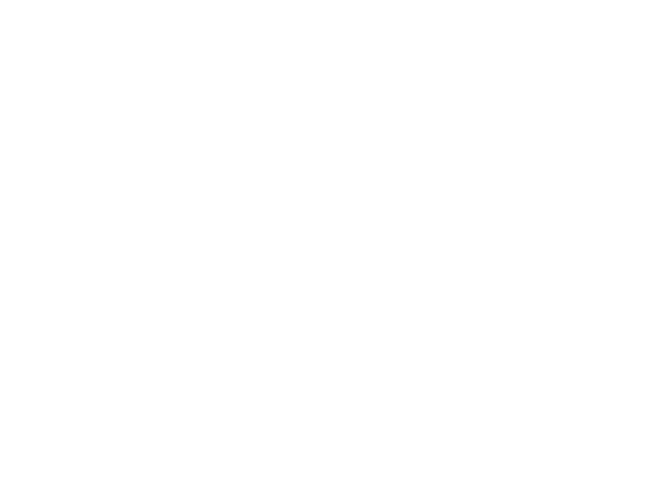

In [93]:
G = nx.Graph()
### BEGIN SOLUTION

### END SOLUTION
nx.draw(G, with_labels=True, node_color='lightblue')

In [94]:
# @title Run to test your graph definition.
G_solution = nx.Graph()
G_solution.add_nodes_from(range(4))
G_solution.add_edges_from([(1, 0), (0, 2), (2, 3), (3, 0)])

if nx.is_isomorphic(G, G_solution):
  print("Your graph plotting function looks correct!")
else:
  print("Something seems wrong. Give it another go!")

Something seems wrong. Give it another go!


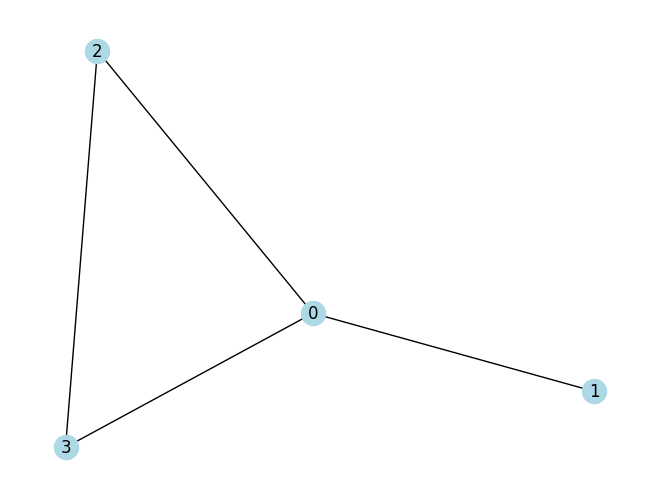

In [95]:
#@title ***Task 1: Solution*** { display-mode: "form" }
G = nx.Graph()
### BEGIN SOLUTION
G.add_nodes_from(range(4))
G.add_edges_from([(1, 0), (0, 2), (2, 3), (3, 0)])
## END SOLUTION
nx.draw(G, with_labels=True, node_color='lightblue')


# **Intro to the jraph Library**
Representing a graph in jraph

In [96]:
def build_toy_graph() -> jraph.GraphsTuple:
  """Define a four node graph, each node has a scalar as its feature."""

  # Nodes are defined implicitly by their features.
  # We will add four nodes, each with a feature, e.g.
  # node 0 has feature [0.],
  # node 1 has featre [2.] etc.
  # len(node_features) is the number of nodes.
  node_features = jnp.array([[0.], [2.], [4.], [6.]])

  # We will now specify 5 directed edges connecting the nodes we defined above.
  # We define this with `senders` (source node indices) and `receivers`
  # (destination node indices).
  # For example, to add an edge from node 0 to node 1, we append 0 to senders,
  # and 1 to receivers.
  # We can do the same for all 5 edges:
  # 0 -> 1
  # 1 -> 2
  # 2 -> 0
  # 3 -> 0
  # 0 -> 3
  senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

  # You can optionally add edge attributes to the 5 edges.
  edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])

  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([4])
  n_edge = jnp.array([5])

  # Optionally you can add `global` information, such as a graph label.
  global_context = jnp.array([[1]]) # Same feature dims as nodes and edges.

  # Now we create the graph.
  graph = jraph.GraphsTuple(
      nodes=node_features,
      edges=edges,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge,
      globals=global_context
      )
  return graph

In [97]:
graph = build_toy_graph()

In [98]:
# Inspecting the GraphsTuple
# Number of nodes
# Note that `n_node` returns an array. The length of `n_node` corresponds to
# the number of graphs stored in one `GraphsTuple`.
# In this case, we only have one graph, so n_node has length 1.
graph.n_node

Array([4], dtype=int32)

In [99]:
# Number of edges
graph.n_edge


Array([5], dtype=int32)

In [100]:
# Node features
graph.nodes

Array([[0.],
       [2.],
       [4.],
       [6.]], dtype=float32)

In [101]:
# Edge features
graph.edges

Array([[5.],
       [6.],
       [7.],
       [8.],
       [8.]], dtype=float32)

In [102]:
# Edges
graph.senders

Array([0, 1, 2, 3, 0], dtype=int32)

In [103]:
graph.receivers

Array([1, 2, 0, 0, 3], dtype=int32)

In [104]:
# Graph-level features
graph.globals

Array([[1]], dtype=int32)

# **Visualizing the Graph**

In [105]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

# **GraphsTuple creation**

In [106]:
# @title Run to test your graph definition.
try:
  assert graph.n_node == 4
  assert jnp.allclose(graph.nodes, jnp.array([[0.], [1.], [2.], [3.]]))
  assert jnp.allclose(graph.senders, jnp.array([1, 0, 2, 3, 0, 2, 3, 0]))
  assert jnp.allclose(graph.receivers, jnp.array([0, 2, 3, 0, 1, 0, 2, 3]))
  assert jnp.allclose(graph.globals, jnp.array([[1]]))
  print("Your graph plotting function looks correct!")
except:
    print("Something seems wrong. Give it another go!")

Something seems wrong. Give it another go!


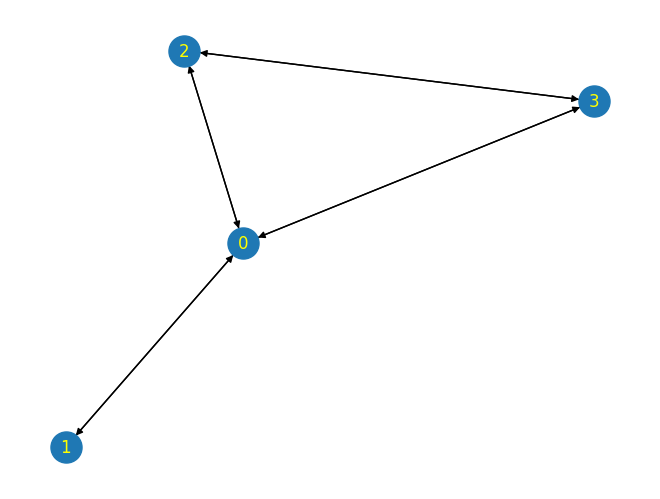

In [107]:
#@title ***Task 2: Solution*** { display-mode: "form" }
### BEGIN SOLUTION
node_features = jnp.array([[0.], [1.], [2.], [3.]])
sender_nodes = [1, 0, 2, 3]
receiver_nodes = [0, 2, 3, 0]
senders = jnp.array(sender_nodes + receiver_nodes)
receivers = jnp.array(receiver_nodes + sender_nodes)

edge_attributes = []
for i in range(4):
  edge_attributes.append([sender_nodes[i] + receiver_nodes[i]])
edges = jnp.array(edge_attributes + edge_attributes)

n_node = jnp.array([4])
n_edge = jnp.array([8])
### END SOLUTION

global_context = jnp.array([[1]])

graph = jraph.GraphsTuple(
    nodes=node_features,
    edges=edges,
    senders=senders,
    receivers=receivers,
    n_node=n_node,
    n_edge=n_edge,
    globals=global_context,
)
draw_jraph_graph_structure(graph)

# **Graph Neural Network Theory**
Implementing GNN Models

Implement MLP baseline

In [108]:
class MLP(hk.Module):
  def __init__(self, widening_factor:int, out_channels:int, number_classes: int = None):
    super().__init__()
    self.widening_factor = widening_factor
    self.out_channels = out_channels
    self.number_classes = number_classes

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:

    mlp = hk.Sequential([hk.Linear(self.out_channels),
                         jax.nn.relu,
                         hk.Linear(self.out_channels * self.widening_factor),
                         jax.nn.relu,
                         hk.Linear(self.out_channels if not self.number_classes else self.number_classes)])

    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(widening_factor = 2, out_channels = 4)(x)

In [109]:
graph = build_toy_graph()

In [110]:
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)

In [111]:
out

Array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-2.4262953 , -0.15340242,  2.5150187 , -1.2854769 ],
       [-4.8525906 , -0.30680484,  5.0300374 , -2.5709538 ],
       [-7.278886  , -0.4602071 ,  7.5450563 , -3.8564317 ]],      dtype=float32)

In [112]:
# Custom update functions

In [113]:
# @title Run to test your update function.
if jnp.allclose(out, jnp.array([[3.], [5.], [7.] ,[9.]])):
  print("Your function looks correct!")
else:
  print("Something seems wrong. Give it another go!")

Something seems wrong. Give it another go!


In [114]:
#@title ***Task 3: Solution*** { display-mode: "form" }
### BEGIN SOLUTION
class Add(hk.Module):
  def __init__(self, number_to_add: int):
    super().__init__()
    self.number_to_add = number_to_add

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    return x + self.number_to_add
### END SOLUTION

print("Before:\n", graph.nodes)
update_node_fn = lambda x: Add(number_to_add=3)(x)
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)
print("After:\n", out)

Before:
 [[0.]
 [2.]
 [4.]
 [6.]]
After:
 [[3.]
 [5.]
 [7.]
 [9.]]


# **Graph Convoutional Network (GCN)**

In [115]:
nodes, _, receivers, senders, _, _, _ = build_toy_graph()
nodes += 1

In [116]:
# Get the total number of nodes
total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]

# Define a function to count the number of sending / receiving edges
count_edges = lambda x: jax.ops.segment_sum(
                jnp.ones_like(senders), x, total_num_nodes)

# Compute the number of sending / receiving edges
sender_degree = count_edges(senders)
receiver_degree = count_edges(receivers)

In [117]:
# Pre normalize by sqrt sender degree.
# Avoid dividing by 0 by taking maximum of (degree, 1).
print("Before:\n", nodes)
nodes = tree.tree_map(
    lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
    nodes,
)
print("\nAfter:\n", nodes)

Before:
 [[1.]
 [3.]
 [5.]
 [7.]]

After:
 [[0.70710677]
 [3.        ]
 [5.        ]
 [7.        ]]


Add Self-Edges to Graph (Edges connecting a node to itself)

In [118]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

# **GCN Layer implementation**

In [119]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                    aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                    add_self_edges: bool = False,
                    symmetric_normalization: bool = True) -> Callable:
    """Returns a method that applies a Graph Convolution layer.

    Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
    NOTE: This implementation does not add an activation after aggregation.
    If you are stacking layers, you may want to add an activation between
    each layer.

    Args:
        update_node_fn: function used to update the nodes. In the paper a single
        layer MLP is used.
        aggregate_nodes_fn: function used to aggregates the sender nodes.
        add_self_edges: whether to add self edges to nodes in the graph as in the
        paper definition of GCN. Defaults to False.
        symmetric_normalization: whether to use symmetric normalization. Defaults to
        True.

    Returns:
        A method that applies a Graph Convolution layer.
    """

    def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Applies a Graph Convolution layer."""
        nodes, _, receivers, senders, _, _, _ = graph

        # First pass nodes through the node updater.
        nodes = update_node_fn(nodes)
        # Equivalent to jnp.sum(n_node), but jittable
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
        if add_self_edges:
            # We add self edges to the senders and receivers so that each node
            # includes itself in aggregation.
            # In principle, a `GraphsTuple` should partition by n_edge, but in
            # this case it is not required since a GCN is agnostic to whether
            # the `GraphsTuple` is a batch of graphs or a single large graph.
            conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                        total_num_nodes)
        else:
            conv_senders = senders
            conv_receivers = receivers

        # pylint: disable=g-long-lambda
        if symmetric_normalization:
            # Calculate the normalization values.
            count_edges = lambda x: jax.ops.segment_sum(
                jnp.ones_like(conv_senders), x, total_num_nodes)
            sender_degree = count_edges(conv_senders)
            receiver_degree = count_edges(conv_receivers)

            # Pre normalize by sqrt sender degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
                nodes,
            )
            # Aggregate the pre-normalized nodes.
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
            # Post normalize by sqrt receiver degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x:
                (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
                nodes,
            )
        else:
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
        # pylint: enable=g-long-lambda
        return graph._replace(nodes=nodes)

    return _ApplyGCN

# **Test General GCN Layer**

In [120]:
gcn_layer = GraphConvolution(
    update_node_fn = lambda n: MLP(widening_factor = 2, out_channels = 4)(n),
    aggregate_nodes_fn = jax.ops.segment_sum,
    add_self_edges = True,
    symmetric_normalization = True
)

In [121]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-4.9526544 , -0.3131313 ,  5.13376   , -2.623969  ],
       [-1.2131476 , -0.0767012 ,  1.2575092 , -0.64273846],
       [-3.639443  , -0.23010363,  3.772528  , -1.9282154 ],
       [-3.6394427 , -0.23010354,  3.772528  , -1.9282157 ]],      dtype=float32)

# **Asymmetric normalization**

In [122]:
def GraphConvolutionNormalize(update_node_fn: Callable,
                              aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                              add_self_edges: bool = False,
                              normalization: bool = True) -> Callable:
    def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        nodes, _, receivers, senders, _, _, _ = graph

        nodes = update_node_fn(nodes)
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
        if add_self_edges:
            conv_receivers, conv_senders = add_self_edges_fn(receivers, senders, total_num_nodes)
        else:
            conv_senders = senders
            conv_receivers = receivers

        # pylint: disable=g-long-lambda
        if normalization:
            ### BEGIN SOLUTION
            nodes = nodes # REMOVE THIS LINE
            ### END SOLUTION
        else:
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
        # pylint: enable=g-long-lambda
        return graph._replace(nodes=nodes)

    return _ApplyGCN

gcn_layer = GraphConvolutionNormalize(
    update_node_fn = lambda n: MLP(widening_factor = 2, out_channels = 4)(n),
    aggregate_nodes_fn = jax.ops.segment_sum,
    add_self_edges = True,
    normalization = True
)

graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-2.4262953 , -0.15340242,  2.5150187 , -1.2854769 ],
       [-4.8525906 , -0.30680484,  5.0300374 , -2.5709538 ],
       [-7.278886  , -0.4602071 ,  7.5450563 , -3.8564317 ]],      dtype=float32)

In [123]:
# @title Run to test your GCN implementation.
expected_out_nodes = jnp.array([
    [-4.0438256, -0.25567064, 4.191698, -2.1424618],
    [-1.2131476, -0.07670121, 1.2575094,-0.64273846],
    [-3.639443  , -0.23010363,  3.7725282 , -1.9282154],
    [-3.639443  , -0.23010355,  3.7725282 , -1.9282159 ],
])

if jnp.allclose(out_graph.nodes, expected_out_nodes):
  print("Your function looks correct!")
else:
  print("Something seems wrong. Give it another go!")

Something seems wrong. Give it another go!


In [124]:
#@title ***Task 4: Solution*** { display-mode: "form" }
def GraphConvolutionNormalize(update_node_fn: Callable,
                              aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                              add_self_edges: bool = False,
                              normalization: bool = True) -> Callable:
    def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        nodes, _, receivers, senders, _, _, _ = graph

        nodes = update_node_fn(nodes)
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
        if add_self_edges:
            conv_receivers, conv_senders = add_self_edges_fn(receivers, senders, total_num_nodes)
        else:
            conv_senders = senders
            conv_receivers = receivers

        # pylint: disable=g-long-lambda
        if normalization:
            ### BEGIN SOLUTION
            # Calculate the node degrees
            count_edges = lambda x: jax.ops.segment_sum(
                jnp.ones_like(conv_senders), x, total_num_nodes)
            receiver_degree = count_edges(conv_receivers)

            # Aggregate the nodes.
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
            # Normalize by receiver degree.
            # Avoid dividing by 0 by taking maximum of (degree, 1).
            nodes = tree.tree_map(
                lambda x:
                (x / jnp.maximum(receiver_degree, 1.0)[:, None]),
                nodes,
            )
            # END SOLUTION
        else:
            nodes = tree.tree_map(
                lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                            total_num_nodes), nodes)
        # pylint: enable=g-long-lambda
        return graph._replace(nodes=nodes)

    return _ApplyGCN

gcn_layer = GraphConvolutionNormalize(
    update_node_fn = lambda n: MLP(widening_factor = 2, out_channels = 4)(n),
    aggregate_nodes_fn = jax.ops.segment_sum,
    add_self_edges = True,
    normalization = True
)

graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-4.0438256 , -0.25567064,  4.191698  , -2.1424618 ],
       [-1.2131476 , -0.07670121,  1.2575094 , -0.64273846],
       [-3.639443  , -0.23010363,  3.7725282 , -1.9282154 ],
       [-3.639443  , -0.23010355,  3.7725282 , -1.9282159 ]],      dtype=float32)

# **Build GCN Model with Multiple Layers**

In [125]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with 3 GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)

    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
        add_self_edges=True)

    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))

    graph = gn(graph)

    return graph

In [126]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-0.32386127,  0.10707338],
       [-0.23884146,  0.07896456],
       [-0.19206828,  0.06350064],
       [-0.23884146,  0.07896456]], dtype=float32)

Node Classification with GCN on Karate Club Dataset

In [127]:
"""Zachary's karate club example.
From https://github.com/deepmind/jraph/blob/master/jraph/examples/zacharys_karate_club.py.
Here we train a graph neural network to process Zachary's karate club.
https://en.wikipedia.org/wiki/Zachary%27s_karate_club
Zachary's karate club is used in the literature as an example of a social graph.
Here we use a graphnet to optimize the assignments of the students in the
karate club to two distinct karate instructors (Mr. Hi and John A).
"""

def get_zacharys_karate_club() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [128]:
graph = get_zacharys_karate_club()

In [129]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')


Number of nodes: 34
Number of edges: 156


# **Visualisation**

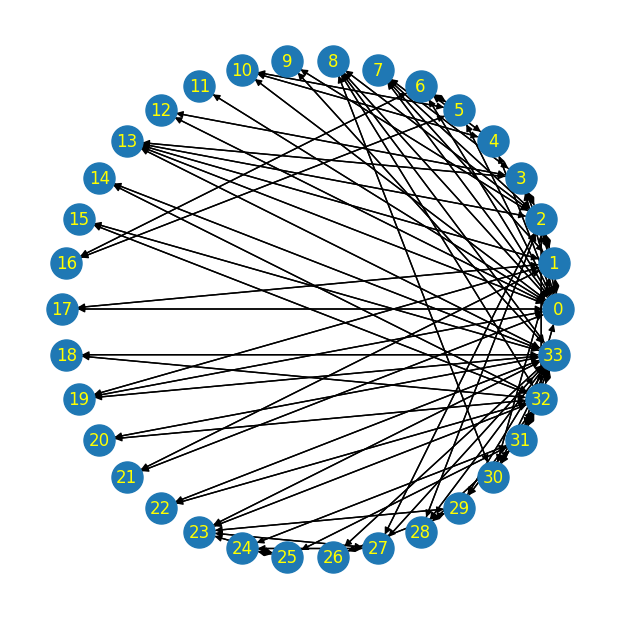

In [130]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

# **GCN Implementation**

In [131]:
def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a GCN for the karate club task.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)
    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2)) # output dim is 2 because we have 2 output classes.
    graph = gn(graph)
    return graph


In [132]:
def optimize_club(network: hk.Transformed, params: hk.Params, \
                  graph_karate_club: jraph.GraphsTuple, labels: jnp.ndarray, \
                  num_steps: int) -> jnp.ndarray:
    """Solves the karate club problem by optimizing the assignments of students."""

    @jax.jit
    def predict(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        return jnp.argmax(decoded_graph.nodes, axis=1)

    @jax.jit
    def prediction_loss(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        # We interpret the decoded nodes as a pair of logits for each node.
        log_prob = jax.nn.log_softmax(decoded_graph.nodes)
        # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
        # and John A (Node 33).
        return -(log_prob[0, 0] + log_prob[33, 1])

    opt_init, opt_update = optax.adam(1e-2)
    opt_state = opt_init(params)

    @jax.jit
    def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
        """Returns updated params and state."""
        g = jax.grad(prediction_loss)(params)
        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state

    @jax.jit
    def accuracy(params: hk.Params) -> jnp.ndarray:
        decoded_graph = network.apply(params, graph_karate_club)
        return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

    for step in range(num_steps):
        print(f"step {step} accuracy {accuracy(params).item():.2f}")
        params, opt_state = update(params, opt_state)

    return predict(params)

In [133]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.06
step 1 accuracy 0.15
step 2 accuracy 0.35
step 3 accuracy 0.50
step 4 accuracy 0.59
step 5 accuracy 0.68
step 6 accuracy 0.71
step 7 accuracy 0.74
step 8 accuracy 0.74
step 9 accuracy 0.76
step 10 accuracy 0.76
step 11 accuracy 0.91
step 12 accuracy 0.91
step 13 accuracy 0.91
step 14 accuracy 0.91


In [134]:
result

Array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

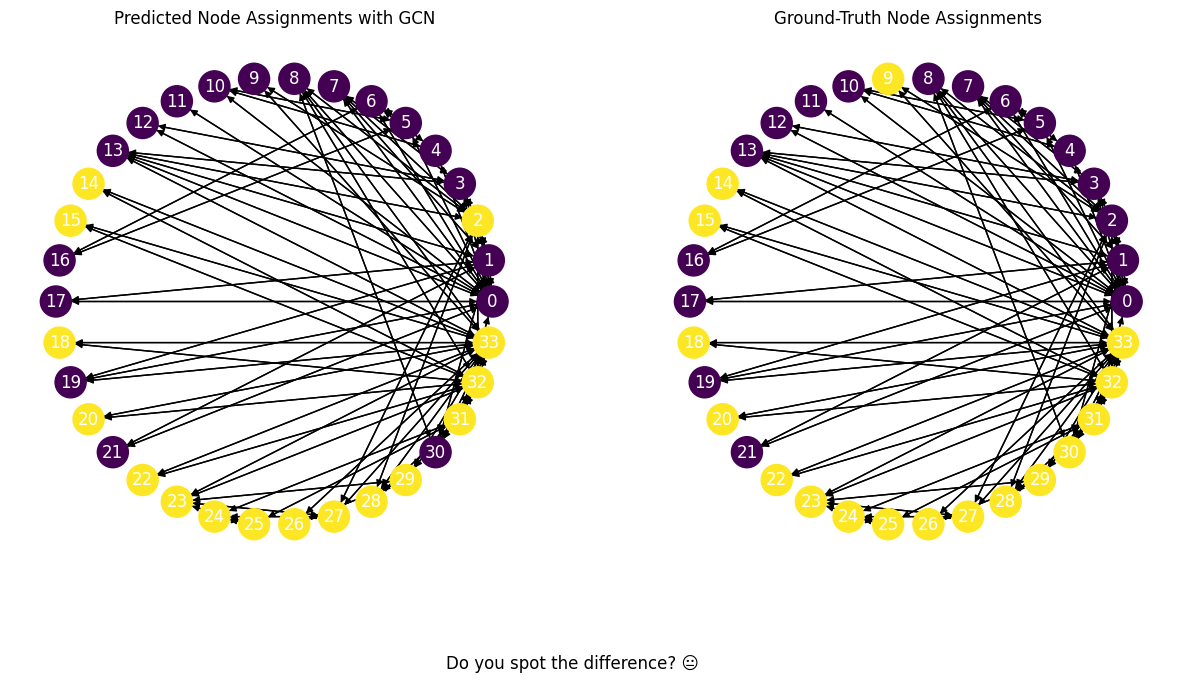

In [135]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

Training a Deeper GCN

5a) 3-Layer GCN

In [136]:
def gcn_3_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    ### BEGIN SOLUTION

    ### END SOLUTION

    return graph

network = hk.without_apply_rng(hk.transform(gcn_3_layer))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.03
step 1 accuracy 0.03
step 2 accuracy 0.03
step 3 accuracy 0.03
step 4 accuracy 0.03
step 5 accuracy 0.03
step 6 accuracy 0.03
step 7 accuracy 0.03
step 8 accuracy 0.03
step 9 accuracy 0.03
step 10 accuracy 0.03
step 11 accuracy 0.03
step 12 accuracy 0.03
step 13 accuracy 0.03
step 14 accuracy 0.03


5b) 5-Layer GCN

In [137]:
def gcn_5_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    ### BEGIN SOLUTION

    ### END SOLUTION

    return graph

network = hk.without_apply_rng(hk.transform(gcn_5_layer))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)


step 0 accuracy 0.03
step 1 accuracy 0.03
step 2 accuracy 0.03
step 3 accuracy 0.03
step 4 accuracy 0.03
step 5 accuracy 0.03
step 6 accuracy 0.03
step 7 accuracy 0.03
step 8 accuracy 0.03
step 9 accuracy 0.03
step 10 accuracy 0.03
step 11 accuracy 0.03
step 12 accuracy 0.03
step 13 accuracy 0.03
step 14 accuracy 0.03


In [138]:
#@title ***Task 5: Solution*** { display-mode: "form" }
def gcn_3_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with 3 GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)

    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
        add_self_edges=True)

    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))

    graph = gn(graph)

    return graph


def gcn_5_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)

    graph = gn(graph)

    for _ in range(3):
      gn = GraphConvolution(
          update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
          add_self_edges=True
        )

      graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))

    graph = gn(graph)

    return graph


graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()

print("----- 3-LAYER GCN -----")
network_3_layer = hk.without_apply_rng(hk.transform(gcn_3_layer))
params = network_3_layer.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network_3_layer, params=params,
                       graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

print("----- 5-LAYER GCN -----")
network_5_layer = hk.without_apply_rng(hk.transform(gcn_5_layer))
params = network_5_layer.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network_5_layer, params=params,
                       graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

----- 3-LAYER GCN -----
step 0 accuracy 0.50
step 1 accuracy 0.65
step 2 accuracy 0.97
step 3 accuracy 0.94
step 4 accuracy 0.94
step 5 accuracy 0.94
step 6 accuracy 0.94
step 7 accuracy 0.94
step 8 accuracy 0.97
step 9 accuracy 0.94
step 10 accuracy 0.94
step 11 accuracy 0.94
step 12 accuracy 0.94
step 13 accuracy 0.97
step 14 accuracy 0.97
----- 5-LAYER GCN -----
step 0 accuracy 0.50
step 1 accuracy 0.53
step 2 accuracy 0.50
step 3 accuracy 0.50
step 4 accuracy 0.50
step 5 accuracy 0.53
step 6 accuracy 0.71
step 7 accuracy 0.68
step 8 accuracy 0.68
step 9 accuracy 0.62
step 10 accuracy 0.62
step 11 accuracy 0.62
step 12 accuracy 0.62
step 13 accuracy 0.68
step 14 accuracy 0.68


In [139]:
def gcn_5_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    ### BEGIN SOLUTION

    ### END SOLUTION

    return graph

network = hk.without_apply_rng(hk.transform(gcn_5_layer))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.03
step 1 accuracy 0.03
step 2 accuracy 0.03
step 3 accuracy 0.03
step 4 accuracy 0.03
step 5 accuracy 0.03
step 6 accuracy 0.03
step 7 accuracy 0.03
step 8 accuracy 0.03
step 9 accuracy 0.03
step 10 accuracy 0.03
step 11 accuracy 0.03
step 12 accuracy 0.03
step 13 accuracy 0.03
step 14 accuracy 0.03


In [140]:
#@title ***Task 5: Solution*** { display-mode: "form" }
def gcn_3_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with 3 GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)

    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
        add_self_edges=True)

    graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))

    graph = gn(graph)

    return graph


def gcn_5_layer(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Defines a graph neural network with more GCN layers.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        output graph with updated node values.
    """
    gn = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True)

    graph = gn(graph)

    for _ in range(3):
      gn = GraphConvolution(
          update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
          add_self_edges=True
        )

      graph = gn(graph)

    gn = GraphConvolution(
        update_node_fn=hk.Linear(2))

    graph = gn(graph)

    return graph


graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()

print("----- 3-LAYER GCN -----")
network_3_layer = hk.without_apply_rng(hk.transform(gcn_3_layer))
params = network_3_layer.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network_3_layer, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

print("----- 5-LAYER GCN -----")
network_5_layer = hk.without_apply_rng(hk.transform(gcn_5_layer))
params = network_5_layer.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network_5_layer, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)


----- 3-LAYER GCN -----
step 0 accuracy 0.50
step 1 accuracy 0.65
step 2 accuracy 0.97
step 3 accuracy 0.94
step 4 accuracy 0.94
step 5 accuracy 0.94
step 6 accuracy 0.94
step 7 accuracy 0.94
step 8 accuracy 0.97
step 9 accuracy 0.94
step 10 accuracy 0.94
step 11 accuracy 0.94
step 12 accuracy 0.94
step 13 accuracy 0.97
step 14 accuracy 0.97
----- 5-LAYER GCN -----
step 0 accuracy 0.50
step 1 accuracy 0.53
step 2 accuracy 0.50
step 3 accuracy 0.50
step 4 accuracy 0.50
step 5 accuracy 0.53
step 6 accuracy 0.71
step 7 accuracy 0.68
step 8 accuracy 0.68
step 9 accuracy 0.62
step 10 accuracy 0.62
step 11 accuracy 0.62
step 12 accuracy 0.62
step 13 accuracy 0.68
step 14 accuracy 0.68


# **Graph Attention Network (GAT)**

In [141]:
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  """Returns a method that applies a Graph Attention Network layer.

  Graph Attention message passing as described in
  https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
  jnp.array, may use edge features for computing attention weights, and
  ignore global features. It does not support nests.
  Args:
    attention_query_fn: function that generates attention queries from sender
      node features.
    attention_logit_fn: function that converts attention queries into logits for
      softmax attention.
    node_update_fn: function that updates the aggregated messages. If None, will
      apply leaky relu and concatenate (if using multi-head attention).

  Returns:
    A function that applies a Graph Attention layer.
  """
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT


# **Test GAT Layer**

In [142]:
def attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                       edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return hk.Linear(1)(x)


gat_layer = GAT(
    attention_query_fn=lambda n: hk.Linear(8)
    (n),  # Applies W to the node features
    attention_logit_fn=attention_logit_fn,
    node_update_fn=None,
    add_self_edges=True,
)

In [143]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gat_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-2.1254564e-02,  2.4042885e+00, -4.0143323e-03, -2.0577878e-02,
         1.8933862e+00,  1.1548431e+00, -5.3817682e-02, -1.0350263e-02],
       [-6.7768171e-03,  7.6658469e-01, -1.2799321e-03, -6.5610623e-03,
         6.0368836e-01,  3.6821082e-01, -1.7159259e-02, -3.3000838e-03],
       [-2.1208903e-02,  2.3991234e+00, -4.0057087e-03, -2.0533672e-02,
         1.8893188e+00,  1.1523622e+00, -5.3702068e-02, -1.0328028e-02],
       [-1.7733721e-02,  2.0060155e+00, -3.3493538e-03, -1.7169129e-02,
         1.5797447e+00,  9.6354210e-01, -4.4902720e-02, -8.6357305e-03]],      dtype=float32)

# **Train GAT Model on Karate Club Dataset**

In [144]:
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

In [145]:
network = hk.without_apply_rng(hk.transform(gat_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)

step 0 accuracy 0.50
step 1 accuracy 0.94
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 0.97
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 0.97
step 14 accuracy 0.97


In [146]:
result

Array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

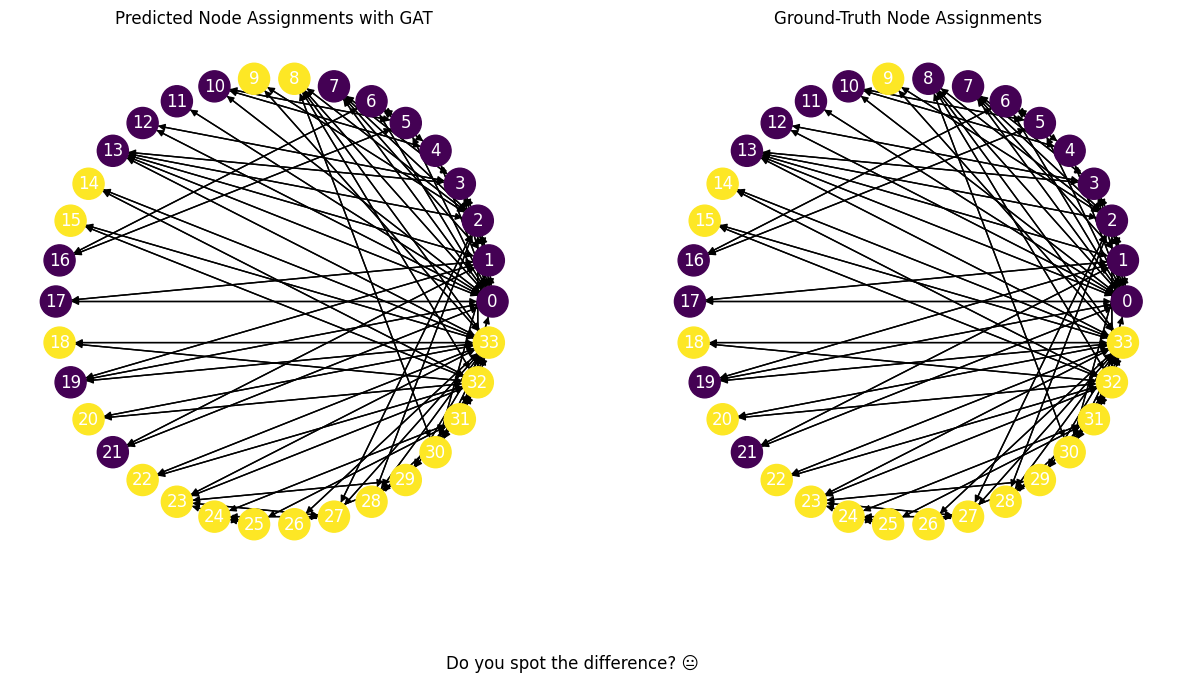

In [147]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GAT')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)
plt.show()

# **Conditioning Attention Coefficients on only the Senders**

In [148]:
### BEGIN SOLUTION
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

network = hk.without_apply_rng(hk.transform(gat_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)
### END SOLUTION

step 0 accuracy 0.50
step 1 accuracy 0.94
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 0.97
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 0.97
step 14 accuracy 0.97


In [149]:
# @title Run to test your GAT implementation.
expected_result = jnp.array([
  0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
], dtype=jnp.int32)

if jnp.allclose(result, expected_result):
  print("Your function looks correct!")
else:
  print("Something seems wrong. Give it another go!")

Something seems wrong. Give it another go!


In [150]:
#@title ***Task 6: Solution*** { display-mode: "form" }

## BEGIN SOLUTION
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    return hk.Linear(1)(sender_attr)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

network = hk.without_apply_rng(hk.transform(gat_definition))
graph_karate_club = get_zacharys_karate_club()
labels = get_ground_truth_assignments_for_zacharys_karate_club()
params = network.init(jax.random.PRNGKey(42), graph_karate_club)

result = optimize_club(network=network, params=params, graph_karate_club=graph_karate_club, labels=labels, num_steps=15)
### END SOLUTION


step 0 accuracy 0.50
step 1 accuracy 0.97
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 1.00
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 1.00
step 14 accuracy 1.00


# ** Graph Classification on MUTAG (Molecules)**

In [151]:
# Download jraph version of MUTAG.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
with open('/tmp/mutag.pickle', 'rb') as f:
  mutag_ds = pickle.load(f)

--2023-10-21 09:53:31--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle’

mutag.pickle        100%[===================>] 344.71K  --.-KB/s    in 0.005s  

2023-10-21 09:53:31 (70.1 MB/s) - ‘/tmp/mutag.pickle’ saved [352981/352981]



In [152]:
len(mutag_ds)

188

In [153]:
# Inspect the first graph
g = mutag_ds[0]['input_graph']
print(f'Number of nodes: {g.n_node[0]}')
print(f'Number of edges: {g.n_edge[0]}')
print(f'Node features shape: {g.nodes.shape}')
print(f'Edge features shape: {g.edges.shape}')

Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)


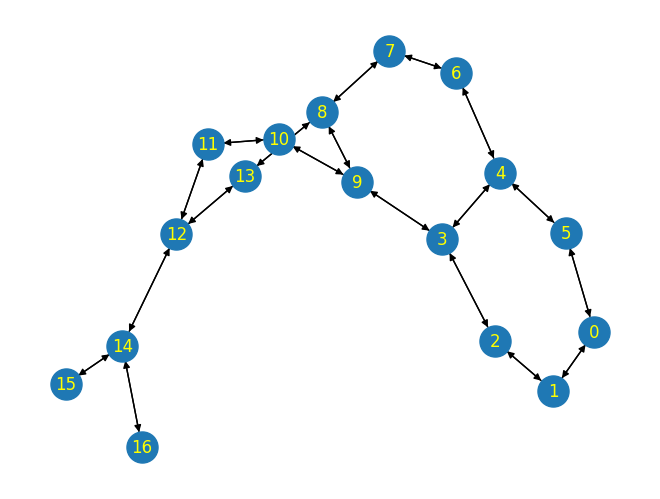

In [154]:
draw_jraph_graph_structure(g)


In [155]:
# Target for first graph
print(f"Target: {mutag_ds[0]['target']}")

Target: [1]


In [156]:
train_mutag_ds = mutag_ds[:150]
test_mutag_ds = mutag_ds[150:]

# **Padding Graphs to Speed Up Training**

In [157]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
  """Computes the nearest power of two greater than x for padding."""
  y = 2
  while y < x:
    y *= 2
  return y

def pad_graph_to_nearest_power_of_two(
    graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Pads a batched `GraphsTuple` to the nearest power of two.
  For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
  would pad the `GraphsTuple` nodes and edges:
    7 nodes --> 8 nodes (2^3)
    5 edges --> 8 edges (2^3)
  And since padding is accomplished using `jraph.pad_with_graphs`, an extra
  graph and node is added:
    8 nodes --> 9 nodes
    3 graphs --> 4 graphs
  Args:
    graphs_tuple: a batched `GraphsTuple` (can be batch size 1).
  Returns:
    A graphs_tuple batched to the nearest power of two.
  """
  # Add 1 since we need at least one padding node for pad_with_graphs.
  pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
  pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
  # Add 1 since we need at least one padding graph for pad_with_graphs.
  # We do not pad to nearest power of two because the batch size is fixed.
  pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
  return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to,
                               pad_graphs_to)

# **Graph Network Model Definition**

In [158]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
@jraph.concatenated_args
def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Edge update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Global update function for graph net."""
  # MUTAG is a binary classification task, so output pos neg logits.
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(2)])
  return net(feats)

def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Add a global paramater for graph classification.
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  embedder = jraph.GraphMapFeatures(
      hk.Linear(128), hk.Linear(128), hk.Linear(128))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  return net(embedder(graph))

# **Loss and Accuracy Function**

In [159]:
def compute_loss(params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss and accuracy."""
  pred_graph = net.apply(params, graph)
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 2)

  # Since we have an extra 'dummy' graph in our batch due to padding, we want
  # to mask out any loss associated with the dummy graph.
  # Since we padded with `pad_with_graphs` we can recover the mask by using
  # get_graph_padding_mask.
  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  loss = -jnp.mean(preds * targets * mask[:, None])

  # Accuracy taking into account the mask.
  accuracy = jnp.sum(
      (jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
  return loss, accuracy

**Training and Evaluation Functions**

Training and evaluation code

In [160]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int, graph_net=net_fn) -> hk.Params:
  """Training loop."""

  # Transform impure `graph_net` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(graph_net))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  # Initialize the network.
  params = net.init(jax.random.PRNGKey(42), graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(
      compute_loss_fn, has_aux=True))

  for idx in range(num_train_steps):
    graph = dataset[idx % len(dataset)]['input_graph']
    label = dataset[idx % len(dataset)]['target']
    # Jax will re-jit your graphnet every time a new graph shape is encountered.
    # In the limit, this means a new compilation every training step, which
    # will result in *extremely* slow training. To prevent this, pad each
    # batch of graphs to the nearest power of two. Since jax maintains a cache
    # of compiled programs, the compilation cost is amortized.
    graph = pad_graph_to_nearest_power_of_two(graph)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    label = jnp.concatenate([label, jnp.array([0])])

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if idx % 50 == 0:
      print(f'step: {idx}, loss: {loss}, acc: {acc}')
  print('Training finished')
  return params

In [161]:
def evaluate(dataset: List[Dict[str, Any]],
             params: hk.Params,
             graph_net = net_fn) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Evaluation Script."""
  # Transform impure `graph_net` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(graph_net))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']
  accumulated_loss = 0
  accumulated_accuracy = 0
  compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']
    graph = pad_graph_to_nearest_power_of_two(graph)
    label = jnp.concatenate([label, jnp.array([0])])
    loss, acc = compute_loss_fn(params, graph, label)
    accumulated_accuracy += acc
    accumulated_loss += loss
    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')
  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss}, accuracy {accuracy}')
  return loss, accuracy

**Train and Evaluate Model**

In [162]:
params = train(train_mutag_ds, num_train_steps=500)

step: 0, loss: 0.28438931703567505, acc: 0.0
step: 50, loss: 0.0006321120890788734, acc: 1.0
step: 100, loss: 0.0013380241580307484, acc: 1.0
step: 150, loss: 0.04702802002429962, acc: 1.0
step: 200, loss: 0.041739627718925476, acc: 1.0
step: 250, loss: 0.0028245325665920973, acc: 1.0
step: 300, loss: 0.047925908118486404, acc: 1.0
step: 350, loss: 0.03225915506482124, acc: 1.0
step: 400, loss: 0.003068581223487854, acc: 1.0
step: 450, loss: 0.036227986216545105, acc: 1.0
Training finished


In [163]:
evaluate(test_mutag_ds, params)

Evaluated 1 graphs
Completed evaluation.
Eval loss: 0.14461465179920197, accuracy 0.7567567825317383


(Array(0.14461465, dtype=float32), Array(0.7567568, dtype=float32))

# **CORA download code**

In [164]:
# Download jraph version of Cora.
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
with open('/tmp/cora.pickle', 'rb') as f:
  cora_ds = pickle.load(f)

--2023-10-21 09:58:21--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15618018 (15M) [application/octet-stream]
Saving to: ‘/tmp/cora.pickle’

cora.pickle         100%[===================>]  14.89M  63.9MB/s    in 0.2s    

2023-10-21 09:58:22 (63.9 MB/s) - ‘/tmp/cora.pickle’ saved [15618018/15618018]



In [165]:
def train_val_test_split_edges(graph: jraph.GraphsTuple,
                               val_perc: float = 0.05,
                               test_perc: float = 0.1):
  """Split edges in input graph into train, val and test splits.

  For val and test sets, also include negative edges.
  Based on torch_geometric.utils.train_test_split_edges.
  """
  mask = graph.senders < graph.receivers
  senders = graph.senders[mask]
  receivers = graph.receivers[mask]
  num_val = int(val_perc * senders.shape[0])
  num_test = int(test_perc * senders.shape[0])
  permuted_indices = onp.random.permutation(range(senders.shape[0]))
  senders = senders[permuted_indices]
  receivers = receivers[permuted_indices]
  if graph.edges is not None:
    edges = graph.edges[permuted_indices]

  val_senders = senders[:num_val]
  val_receivers = receivers[:num_val]
  if graph.edges is not None:
    val_edges = edges[:num_val]

  test_senders = senders[num_val:num_val + num_test]
  test_receivers = receivers[num_val:num_val + num_test]
  if graph.edges is not None:
    test_edges = edges[num_val:num_val + num_test]

  train_senders = senders[num_val + num_test:]
  train_receivers = receivers[num_val + num_test:]
  train_edges = None
  if graph.edges is not None:
    train_edges = edges[num_val + num_test:]

  # make training edges undirected by adding reverse edges back in
  train_senders_undir = jnp.concatenate((train_senders, train_receivers))
  train_receivers_undir = jnp.concatenate((train_receivers, train_senders))
  train_senders = train_senders_undir
  train_receivers = train_receivers_undir

  # Negative edges.
  num_nodes = graph.n_node[0]
  # Create a negative adjacency mask, s.t. mask[i, j] = True iff edge i->j does
  # not exist in the original graph.
  neg_adj_mask = onp.ones((num_nodes, num_nodes), dtype=onp.uint8)
  # upper triangular part
  neg_adj_mask = onp.triu(neg_adj_mask, k=1)
  neg_adj_mask[graph.senders, graph.receivers] = 0
  neg_adj_mask = neg_adj_mask.astype(onp.bool)
  neg_senders, neg_receivers = neg_adj_mask.nonzero()

  perm = onp.random.permutation(range(len(neg_senders)))
  neg_senders = neg_senders[perm]
  neg_receivers = neg_receivers[perm]

  val_neg_senders = neg_senders[:num_val]
  val_neg_receivers = neg_receivers[:num_val]
  test_neg_senders = neg_senders[num_val:num_val + num_test]
  test_neg_receivers = neg_receivers[num_val:num_val + num_test]

  train_graph = jraph.GraphsTuple(
      nodes=graph.nodes,
      edges=train_edges,
      senders=train_senders,
      receivers=train_receivers,
      n_node=graph.n_node,
      n_edge=jnp.array([len(train_senders)]),
      globals=graph.globals)

  return train_graph, neg_adj_mask, val_senders, val_receivers, val_neg_senders, val_neg_receivers, test_senders, test_receivers, test_neg_senders, test_neg_receivers


In [168]:
graph = cora_ds[0]['input_graph']
train_graph, neg_adj_mask, val_pos_senders, val_pos_receivers, val_neg_senders, val_neg_receivers, test_pos_senders,test_pos_receivers, test_neg_senders, test_neg_receivers = train_val_test_split_edges(graph)


<ipython-input-165-63a5329ac9b7>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neg_adj_mask = neg_adj_mask.astype(onp.bool)


In [169]:
print(f'Train set: {train_graph.senders.shape[0]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {val_pos_senders.shape[0]} positive edges, {val_neg_senders.shape[0]} negative edges')
print(f'Test set: {test_pos_senders.shape[0]} positive edges, {test_neg_senders.shape[0]} negative edges')
print(f'Negative adjacency mask shape: {neg_adj_mask.shape}')
print(f'Number of negative edges to sample from: {neg_adj_mask.sum()}')

Train set: 8976 positive edges, we will sample the same number of negative edges at runtime
Val set: 263 positive edges, 263 negative edges
Test set: 527 positive edges, 527 negative edges
Negative adjacency mask shape: (2708, 2708)
Number of negative edges to sample from: 3660000


# **Graph Network Model Definition**

In [170]:
@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(64)])
  return net(feats)


def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Network definition."""
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn, update_edge_fn=None, update_global_fn=None)
  return net(graph)


def decode(pred_graph: jraph.GraphsTuple, senders: jnp.ndarray,
           receivers: jnp.ndarray) -> jnp.ndarray:
  """Given a set of candidate edges, take dot product of respective nodes.

  Args:
    pred_graph: input graph.
    senders: Senders of candidate edges.
    receivers: Receivers of candidate edges.

  Returns:
    For each edge, computes dot product of the features of the two nodes.

  """
  return jnp.squeeze(
      jnp.sum(pred_graph.nodes[senders] * pred_graph.nodes[receivers], axis=1))

In [171]:
# Loss and ROC-AUC-Metric Function
from sklearn.metrics import roc_auc_score

def compute_bce_with_logits_loss(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes binary cross-entropy with logits loss.

  Combines sigmoid and BCE, and uses log-sum-exp trick for numerical stability.
  See https://stackoverflow.com/a/66909858 if you want to learn more.

  Args:
    x: Predictions (logits).
    y: Labels.

  Returns:
    Binary cross-entropy loss with mean aggregation.

  """
  max_val = jnp.clip(x, 0, None)
  loss = x - x * y + max_val + jnp.log(
      jnp.exp(-max_val) + jnp.exp((-x - max_val)))
  return loss.mean()


def compute_loss(params: hk.Params, graph: jraph.GraphsTuple,
                 senders: jnp.ndarray, receivers: jnp.ndarray,
                 labels: jnp.ndarray,
                 net: hk.Transformed) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss."""
  pred_graph = net.apply(params, graph)
  preds = decode(pred_graph, senders, receivers)
  loss = compute_bce_with_logits_loss(preds, labels)
  return loss, preds


def compute_roc_auc_score(preds: jnp.ndarray,
                          labels: jnp.ndarray) -> jnp.ndarray:
  """Computes roc auc (area under the curve) score for classification."""
  s = jax.nn.sigmoid(preds)
  roc_auc = roc_auc_score(labels, s)
  return roc_auc


In [175]:
def negative_sampling(
    graph: jraph.GraphsTuple, num_neg_samples: int,
    key: jnp.DeviceArray) -> Tuple[jnp.DeviceArray, jnp.DeviceArray]:
  """Samples negative edges, i.e. edges that don't exist in the input graph."""
  num_nodes = graph.n_node[0]
  total_possible_edges = num_nodes**2
  # convert 2D edge indices to 1D representation.
  pos_idx = graph.senders * num_nodes + graph.receivers

  # Percentage to oversample edges, so most likely will sample enough neg edges.
  alpha = jnp.abs(1 / (1 - 1.1 *
                       (graph.senders.shape[0] / total_possible_edges)))

  perm = jax.random.randint(
      key,
      shape=(int(alpha * num_neg_samples),),
      minval=0,
      maxval=total_possible_edges,
      dtype=jnp.uint32)

  # mask where sampled edges are positive edges.
  mask = jnp.isin(perm, pos_idx)
  # remove positive edges.
  perm = perm[~mask][:num_neg_samples]

  # convert 1d back to 2d edge indices.
  neg_senders = perm // num_nodes
  neg_receivers = perm % num_nodes

  return neg_senders, neg_receivers

AttributeError: ignored

In [173]:
def train(dataset: List[Dict[str, Any]], num_epochs: int) -> hk.Params:
  """Training loop."""
  key = jax.random.PRNGKey(42)
  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  train_graph, _, val_pos_s, val_pos_r, val_neg_s, val_neg_r, test_pos_s, \
      test_pos_r, test_neg_s, test_neg_r = train_val_test_split_edges(
      graph)

  # Prepare the validation and test data.
  val_senders = jnp.concatenate((val_pos_s, val_neg_s))
  val_receivers = jnp.concatenate((val_pos_r, val_neg_r))
  val_labels = jnp.concatenate(
      (jnp.ones(len(val_pos_s)), jnp.zeros(len(val_neg_s))))
  test_senders = jnp.concatenate((test_pos_s, test_neg_s))
  test_receivers = jnp.concatenate((test_pos_r, test_neg_r))
  test_labels = jnp.concatenate(
      (jnp.ones(len(test_pos_s)), jnp.zeros(len(test_neg_s))))
  # Initialize the network.
  params = net.init(key, train_graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(1e-4)
  opt_state = opt_init(params)

  compute_loss_fn = functools.partial(compute_loss, net=net)
  # We jit the computation of our loss, since this is the main computation.
  # Using jax.jit means that we will use a single accelerator. If you want
  # to use more than 1 accelerator, use jax.pmap. More information can be
  # found in the jax documentation.
  compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

  for epoch in range(num_epochs):
    num_neg_samples = train_graph.senders.shape[0]
    train_neg_senders, train_neg_receivers = negative_sampling(
        train_graph, num_neg_samples=num_neg_samples, key=key)
    train_senders = jnp.concatenate((train_graph.senders, train_neg_senders))
    train_receivers = jnp.concatenate(
        (train_graph.receivers, train_neg_receivers))
    train_labels = jnp.concatenate(
        (jnp.ones(len(train_graph.senders)), jnp.zeros(len(train_neg_senders))))

    (train_loss,
     train_preds), grad = compute_loss_fn(params, train_graph, train_senders,
                                          train_receivers, train_labels)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if epoch % 10 == 0 or epoch == (num_epochs - 1):
      train_roc_auc = compute_roc_auc_score(train_preds, train_labels)
      val_loss, val_preds = compute_loss(params, train_graph, val_senders,
                                         val_receivers, val_labels, net)
      val_roc_auc = compute_roc_auc_score(val_preds, val_labels)
      print(f'epoch: {epoch}, train_loss: {train_loss:.3f}, '
            f'train_roc_auc: {train_roc_auc:.3f}, val_loss: {val_loss:.3f}, '
            f'val_roc_auc: {val_roc_auc:.3f}')
  test_loss, test_preds = compute_loss(params, train_graph, test_senders,
                                       test_receivers, test_labels, net)
  test_roc_auc = compute_roc_auc_score(test_preds, test_labels)
  print('Training finished')
  print(
      f'epoch: {epoch}, test_loss: {test_loss:.3f}, test_roc_auc: {test_roc_auc:.3f}'
  )
  return params

In [174]:
params = train(cora_ds, num_epochs=200)

<ipython-input-165-63a5329ac9b7>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neg_adj_mask = neg_adj_mask.astype(onp.bool)


NameError: ignored